In [1]:
from langchain.chat_models import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
from langchain.chains import create_tagging_chain, create_tagging_chain_pydantic


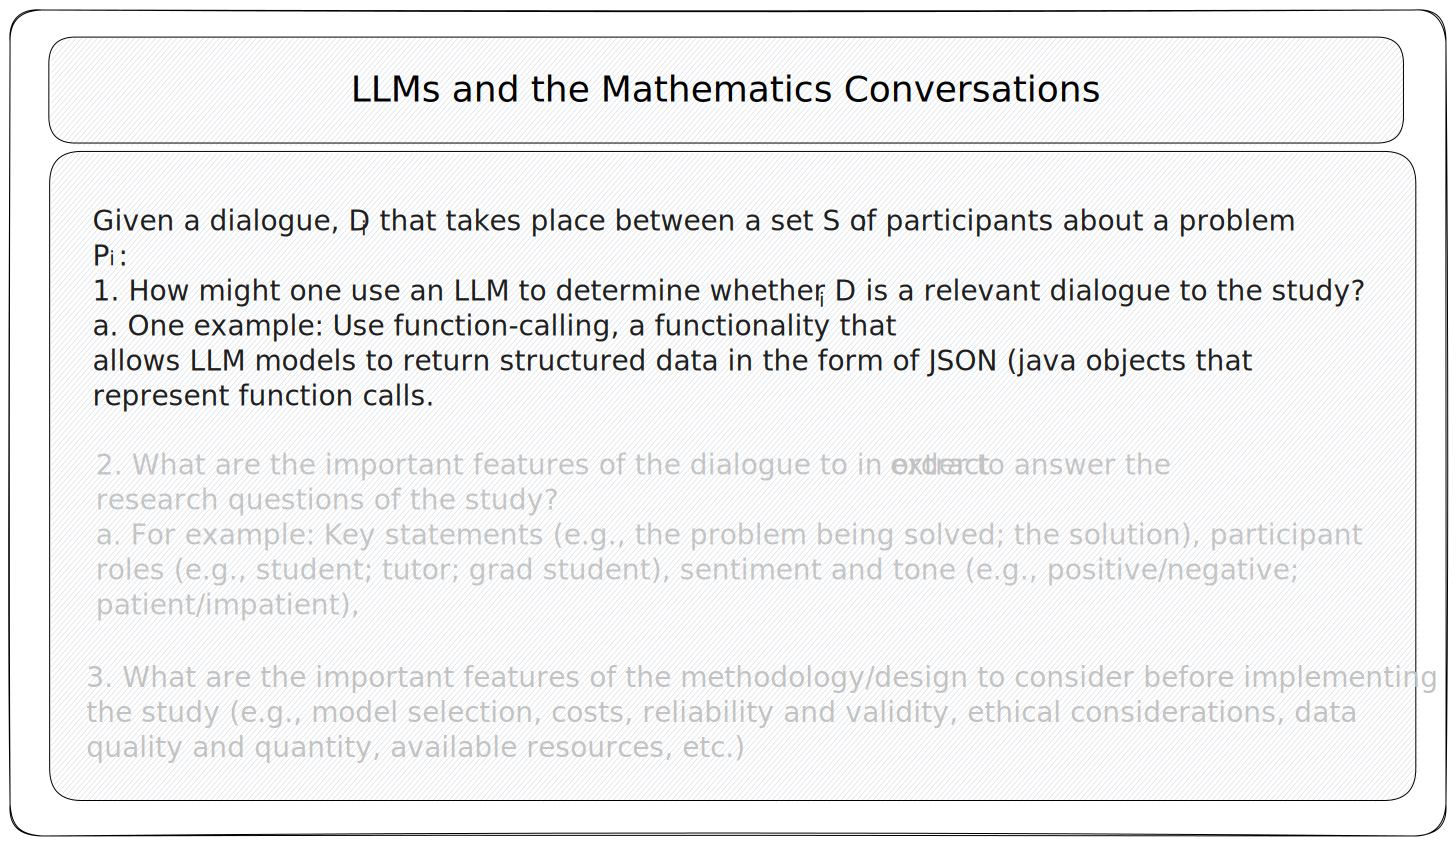

In [75]:
display(SVG(filename='../../../Desktop/presentation_dissertation/slide_8_3.svg'))

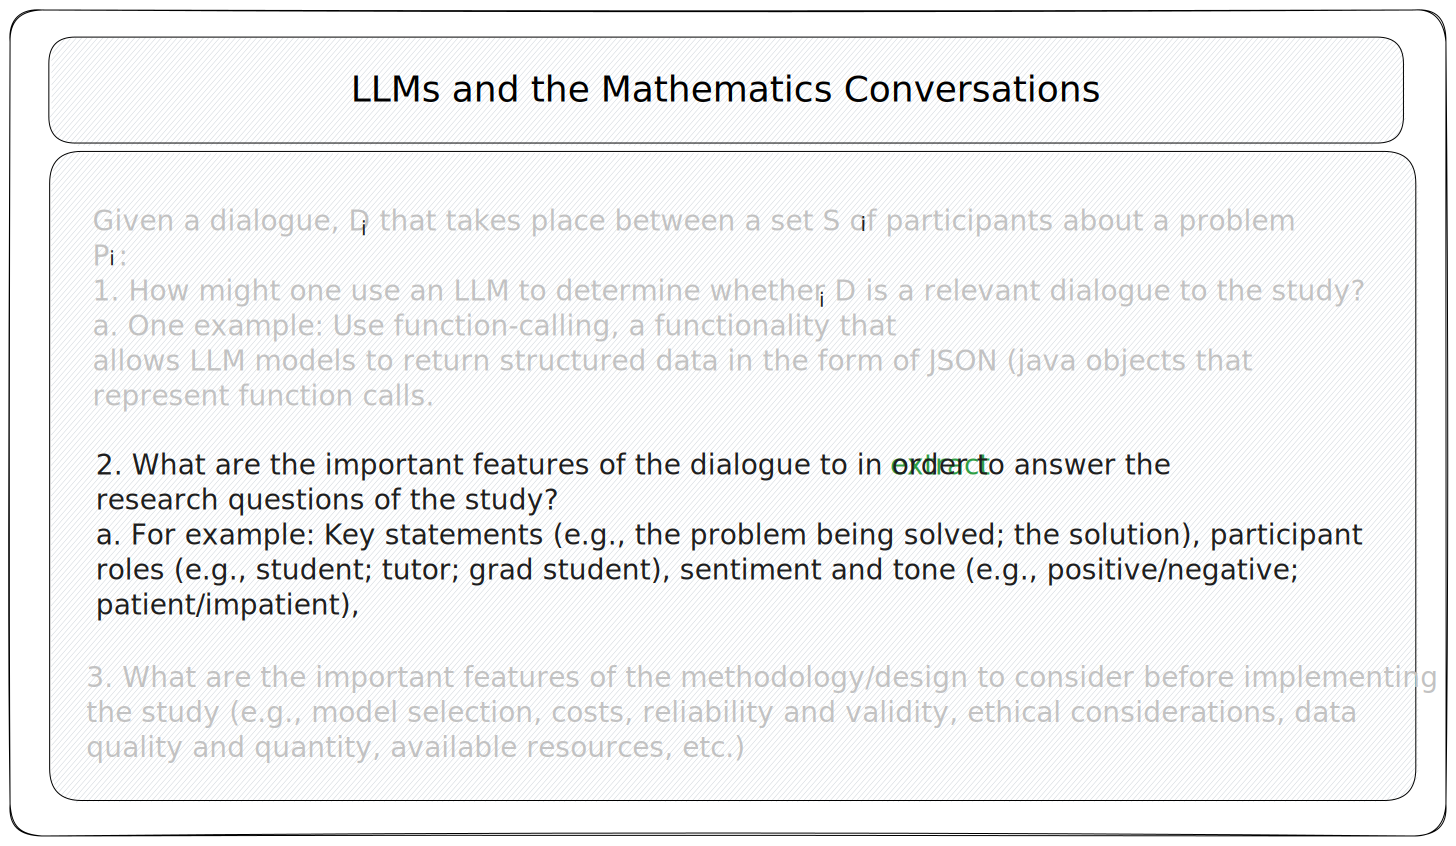

In [73]:
display(SVG(filename='../../../Desktop/presentation_dissertation/slide_8_1.svg'))

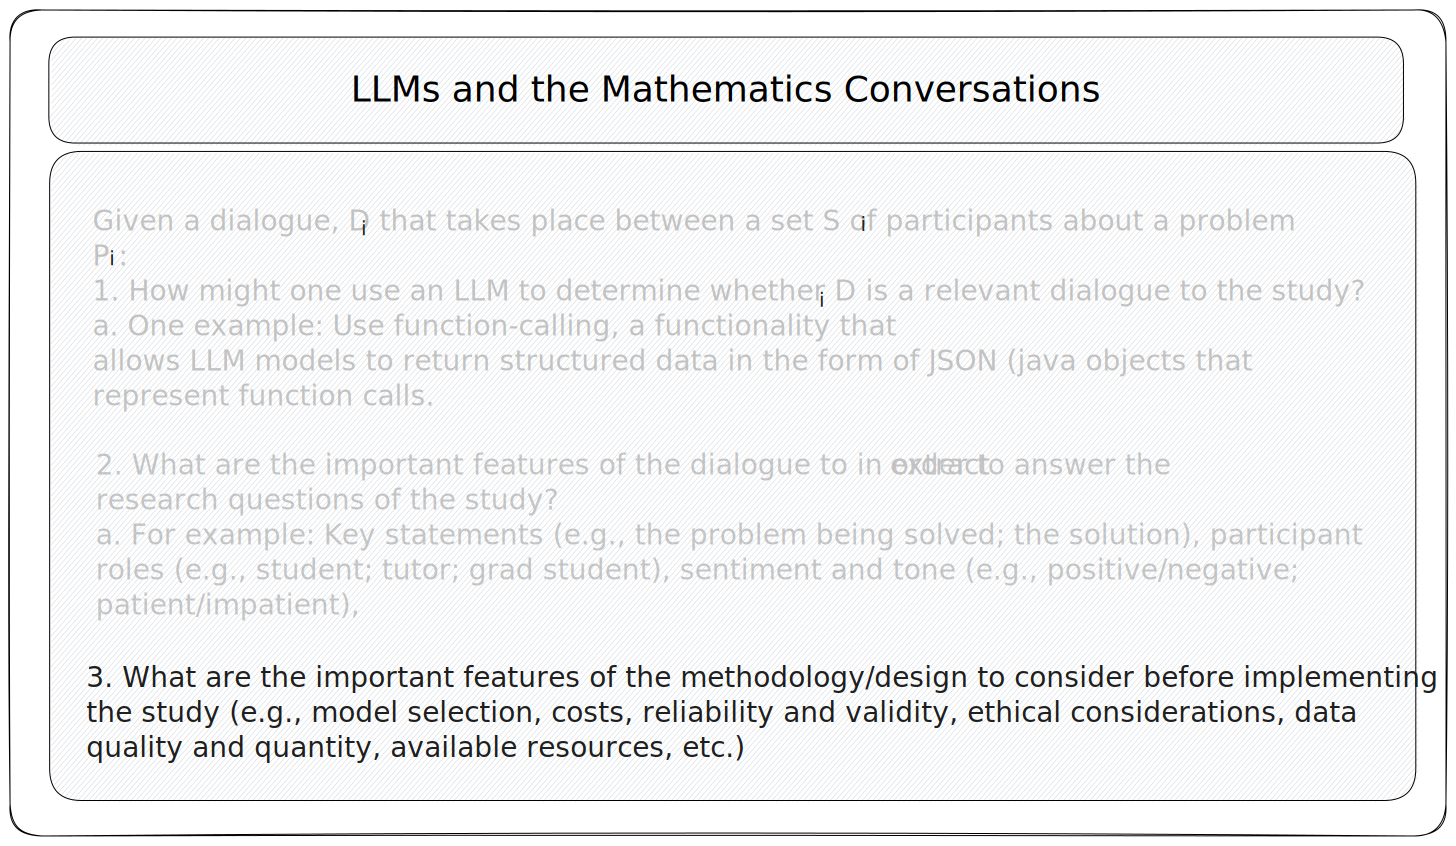

In [74]:
display(SVG(filename='../../../Desktop/presentation_dissertation/slide_8_2.svg'))

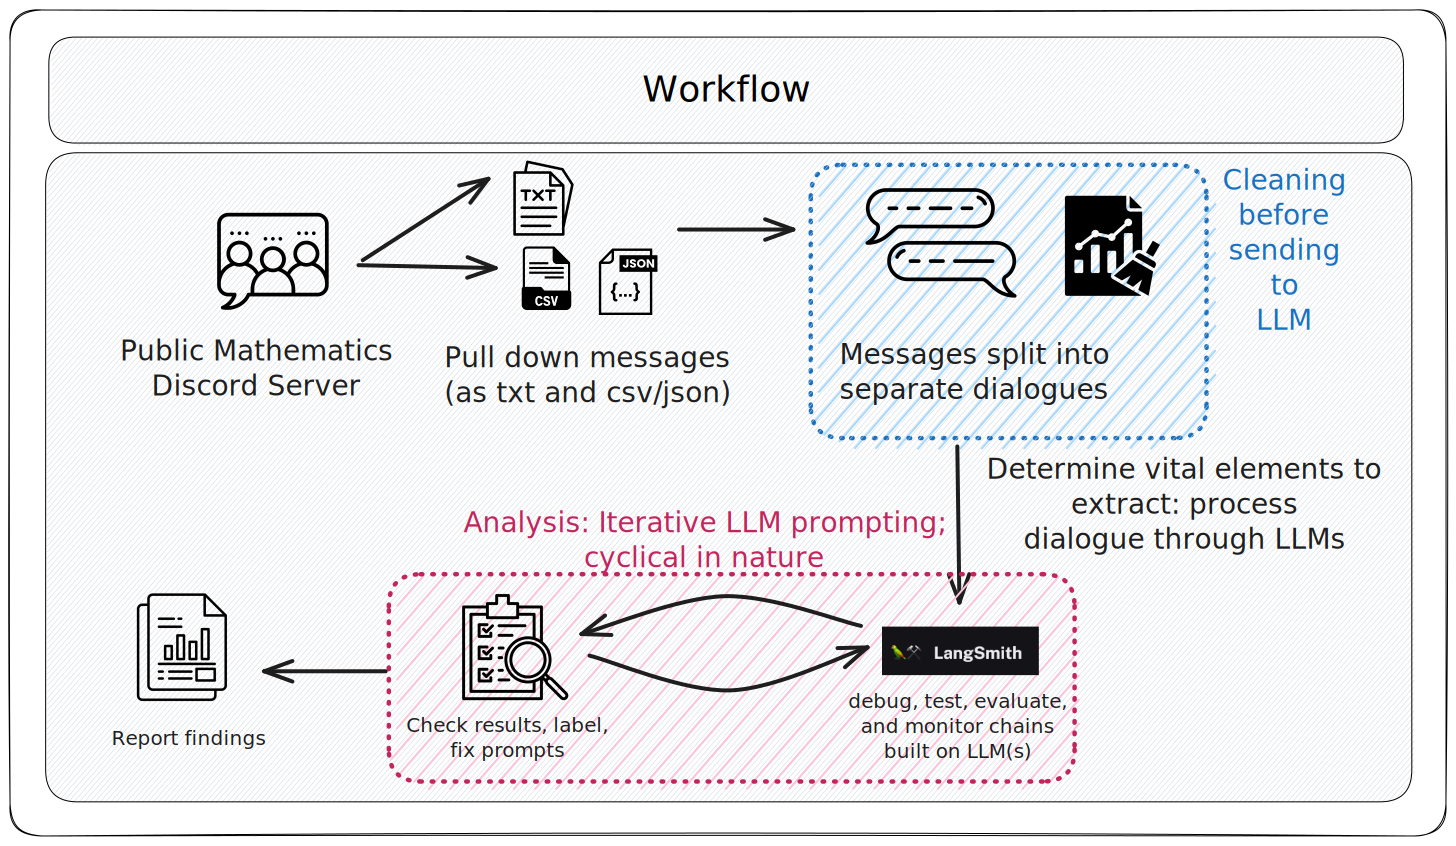

In [76]:
display(SVG(filename='../../../Desktop/presentation_dissertation/slide_9.svg'))

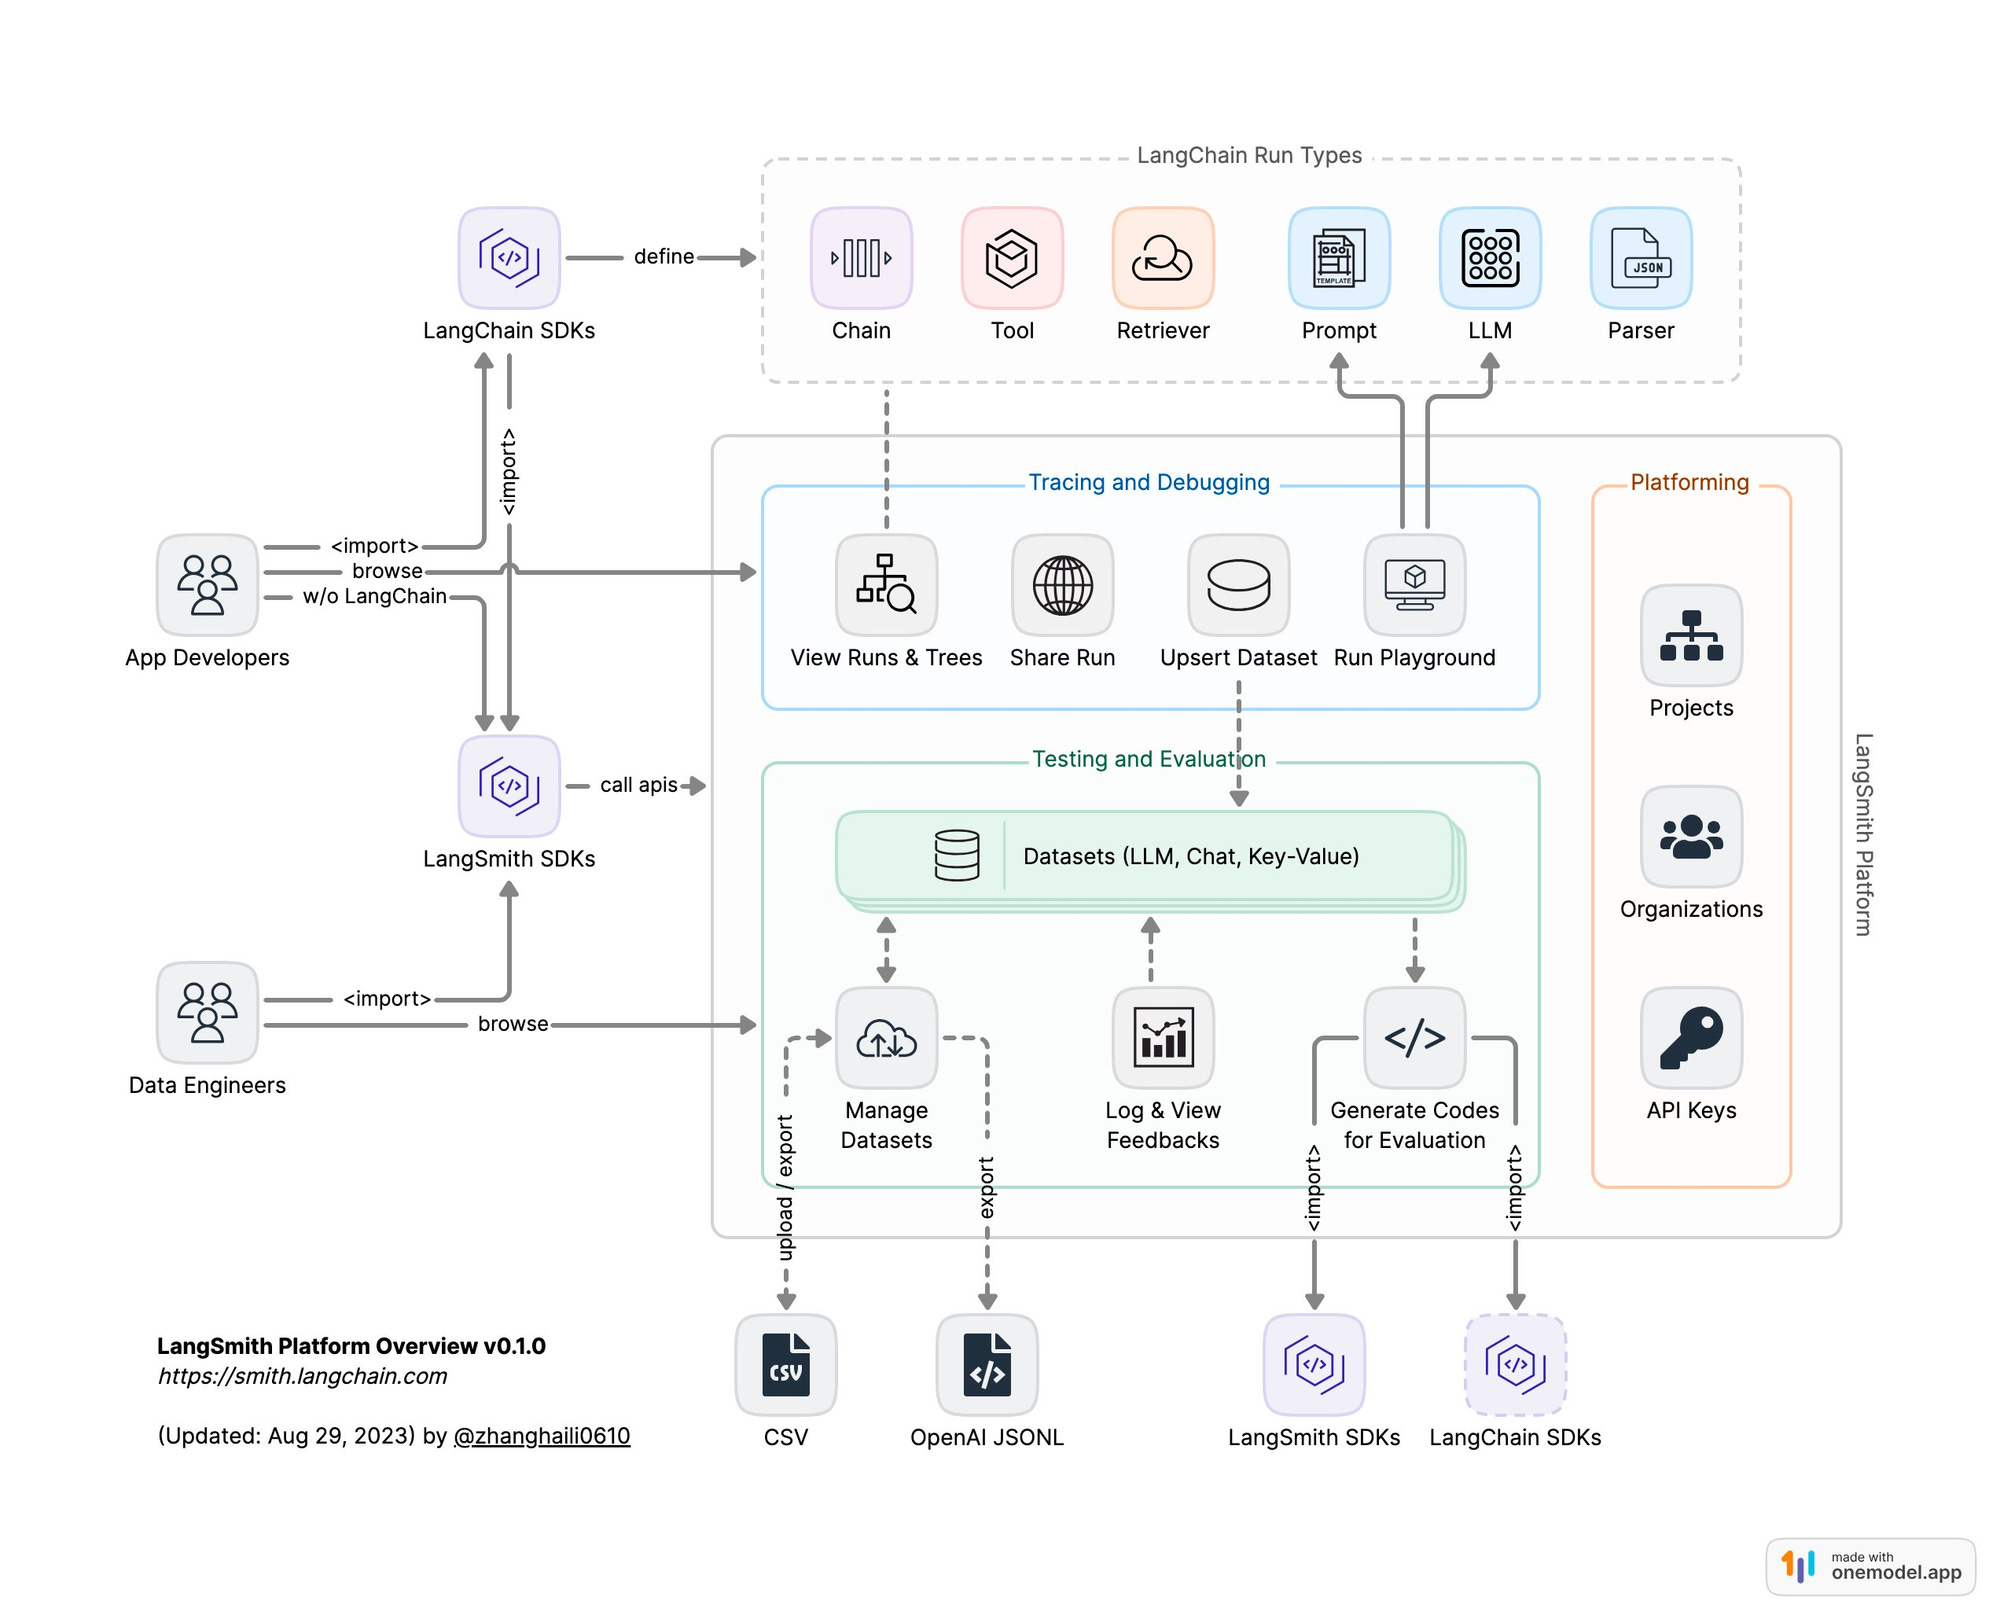

In [6]:
display(Image(filename='images/langsmith.jpg'))

In [9]:
import tiktoken

# Schema
schema_1 = {
    "properties": {
        "problem": {"type": "string", "description": "What is the problem the student is working on?"},
        "derivative": {"type": "string", "description": "Does the problem involve the use of the derivative?"},
        "derivative_type": {"type": "string", "description": "What type of derivative is used?"},
    },
    "required": ["problem", "derivative", "derivative_type"],
}

# LLM
llm = ChatOpenAI(temperature=0, model="gpt-3.5-turbo-0613")
chain = create_tagging_chain(schema_1, llm)

In [10]:
def count_tokens(text, encoding_name="gpt-3.5-turbo"):
    encoding = tiktoken.encoding_for_model(encoding_name)
    num_tokens = len(encoding.encode(text))
    print(num_tokens)
    return num_tokens

In [11]:
def extract_content(json_data, max_tokens=4096, delimiter=' '):
    # Extract the 'content' field from each message
    messages = [msg['content'] for msg in json_data['messages'] if msg['canLabel']]

    # Concatenate these messages
    content = delimiter.join(messages)

    return content

In [13]:
# Load data
import json
with open(file = "./data/langchain_jsons/conversation_2.json") as f:
    data = json.load(f)


inp = extract_content(data)
chain.run(inp)

{'problem': 'differentiating with respect to x',
 'derivative': 'fundamental theorem of calculus',
 'derivative_type': 'chain rule'}

In [14]:
from langchain.document_loaders import JSONLoader

In [28]:
from pathlib import Path
from pprint import pprint


file_path='./data/jsons/output_help-40/40-6.json'
data = json.loads(Path(file_path).read_text())

In [29]:
pprint(data)

{'dialogue': [{'author': 'Mathematics Bot:',
               'text': 'Available help channel!',
               'timestamp': '12/05/2021 16:17:03'},
              {'author': 'Abbey, Margaret:',
               'text': '',
               'timestamp': '12/05/2021 16:27:10',
               'url': 'https://cdn.discordapp.com/attachments/908078124405755914/917165224233152512/f7fe246c2560d3fe8289b52b2fe57419.png'},
              {'author': 'Mathematics Bot:',
               'text': 'Pinned a message.',
               'timestamp': '12/05/2021 16:27:10'},
              {'author': 'Abbey, Margaret:',
               'text': 'can someone help me out with thsi question please?',
               'timestamp': '12/05/2021 16:27:15'},
              {'author': 'Abbey, Anne Merton:',
               'text': '$\\int_{g(x)}^{h(x)} = \\int_{a}^{h(x)} + '
                       '\\int_{g(x)}^{a} = \\int_{a}^{h(x)} - '
                       '\\int_{a}^{g(x)}$',
               'timestamp': '12/05/2021 16:37:17'},

In [36]:
loader = JSONLoader(
    file_path='./data/langchain_jsons/conversation_2.json',
    jq_schema='.messages[].content')

data = loader.load()

In [37]:
pprint(data)

[Document(page_content='', metadata={'source': '/mnt/c/Users/mrmik/Dropbox (University of Michigan)/mike_dissertation/disentangle-help-channels/data/langchain_jsons/conversation_2.json', 'seq_num': 1}),
 Document(page_content='', metadata={'source': '/mnt/c/Users/mrmik/Dropbox (University of Michigan)/mike_dissertation/disentangle-help-channels/data/langchain_jsons/conversation_2.json', 'seq_num': 2}),
 Document(page_content='Pinned a message.', metadata={'source': '/mnt/c/Users/mrmik/Dropbox (University of Michigan)/mike_dissertation/disentangle-help-channels/data/langchain_jsons/conversation_2.json', 'seq_num': 3}),
 Document(page_content='can you do this?', metadata={'source': '/mnt/c/Users/mrmik/Dropbox (University of Michigan)/mike_dissertation/disentangle-help-channels/data/langchain_jsons/conversation_2.json', 'seq_num': 4}),
 Document(page_content='im supposed to be differentiating this with respect to x', metadata={'source': '/mnt/c/Users/mrmik/Dropbox (University of Michigan)

In [143]:
import requests
import json
from pix2text import Pix2Text, merge_line_texts

# Functions for image recognition and saving/loading results
def download_image(url: str, save_path: str) -> None:
    response = requests.get(url)
    with open(save_path, 'wb') as file:
        file.write(response.content)

def recognize_image_from_url(url: str) -> str:
    temp_image_path = './temp_image.jpg'
    download_image(url, temp_image_path)
    p2t = Pix2Text(analyzer_config=dict(model_name='mfd'))
    outs = p2t(temp_image_path, resized_shape=600)
    return merge_line_texts(outs, auto_line_break=True)


def load_data_from_json(filename: str) -> list:
    with open(filename, 'r') as file:
        return json.load(file)

def custom_serializer(obj):
    """
    Custom JSON serializer for objects not serializable by default json code.
    """
    # Check if the object is an instance of the Document class (or any other non-serializable classes)
    if isinstance(obj, Document):
        # Convert the Document object to a dictionary or any other serializable format
        return obj.__dict__ # This assumes the Document object can be represented as a dictionary
    # For any other non-serializable object types, you can add more conditions here
    # ...
    # If the object is not of any type we can handle, raise an error
    raise TypeError(f"Type not serializable: {type(obj)}")


# Define the metadata extraction function.
def metadata_func(record: dict, metadata: dict) -> dict:

    # Comment author, timestamp, url if data comes from data/jsons/output_help-40
    # Fix for future do try, except of if statement here. Otherwise just have all data have same structure once we figure it out
    metadata["author"] = record.get("author")
    metadata["timestamp"] = record.get("timestamp")
    metadata["url"] = record.get("url")

    # Check if the record has a "url" and it doesn't have "recognized_text"

    # This provides the image to text generation for the attached image
    if metadata["url"] and "recognized_text" not in record:
        metadata["recognized_text"] = recognize_image_from_url(metadata["url"])
    ## Uncomment these if using ./data/langchain_json
    # metadata["username"] = record.get("user", {}).get("name") for the langchain_json files
    # metadata["timestamp"] = record.get("timestampUsec") for the langchain_json files

    return metadata

loader = JSONLoader(
    file_path='./data/jsons/output_help-40/40-6.json',
    jq_schema='.dialogue[]',
    content_key="text",
    metadata_func=metadata_func
)
data = loader.load()

# Process each URL in the data and save recognized text
for entry in data:
    # Check if the entry is a dictionary
    if isinstance(entry, dict):
        url = entry.get("url")
        
        # Check if recognized text already exists for the URL
        if url and "recognized_text" not in entry:
            entry["recognized_text"] = recognize_image_from_url(url)
            print(f"Recognized text from {url}:")
            print(entry["recognized_text"])
            print("-" * 50)
    else:
        # Print the type and value of the entry if it's not a dictionary
        print(f"Unexpected data type: {type(entry)}")
        print(entry)
        print("-" * 50)



[WARNING 2023-09-01 13:27:55,739 _showwarnmsg:109] /mnt/c/Users/mrmik/Dropbox (University of Michigan)/mike_dissertation/disentangle-help-channels/env_linux/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
 


Unexpected data type: <class 'langchain.schema.document.Document'>
page_content='Available help channel!' metadata={'source': '/mnt/c/Users/mrmik/Dropbox (University of Michigan)/mike_dissertation/disentangle-help-channels/data/jsons/output_help-40/40-6.json', 'seq_num': 1, 'author': 'Mathematics Bot:', 'timestamp': '12/05/2021 16:17:03', 'url': None}
--------------------------------------------------
Unexpected data type: <class 'langchain.schema.document.Document'>
page_content='' metadata={'source': '/mnt/c/Users/mrmik/Dropbox (University of Michigan)/mike_dissertation/disentangle-help-channels/data/jsons/output_help-40/40-6.json', 'seq_num': 2, 'author': 'Abbey, Margaret:', 'timestamp': '12/05/2021 16:27:10', 'url': 'https://cdn.discordapp.com/attachments/908078124405755914/917165224233152512/f7fe246c2560d3fe8289b52b2fe57419.png', 'recognized_text': '(1 point) Find the derivative of the following function\n$$\nF(x)=\\int_{x^{3}}^{x^{4}}(2t-1)^{3}\\,d t\n$$\nusing the Fundamental Th

In [144]:
pprint(data)

[Document(page_content='Available help channel!', metadata={'source': '/mnt/c/Users/mrmik/Dropbox (University of Michigan)/mike_dissertation/disentangle-help-channels/data/jsons/output_help-40/40-6.json', 'seq_num': 1, 'author': 'Mathematics Bot:', 'timestamp': '12/05/2021 16:17:03', 'url': None}),
 Document(page_content='', metadata={'source': '/mnt/c/Users/mrmik/Dropbox (University of Michigan)/mike_dissertation/disentangle-help-channels/data/jsons/output_help-40/40-6.json', 'seq_num': 2, 'author': 'Abbey, Margaret:', 'timestamp': '12/05/2021 16:27:10', 'url': 'https://cdn.discordapp.com/attachments/908078124405755914/917165224233152512/f7fe246c2560d3fe8289b52b2fe57419.png', 'recognized_text': '(1 point) Find the derivative of the following function\n$$\nF(x)=\\int_{x^{3}}^{x^{4}}(2t-1)^{3}\\,d t\n$$\nusing the Fundamental Theorem of Calculus\nF"(z)=\n'}),
 Document(page_content='Pinned a message.', metadata={'source': '/mnt/c/Users/mrmik/Dropbox (University of Michigan)/mike_dissert

In [145]:
from langchain.document_transformers.openai_functions import create_metadata_tagger
from langchain.prompts import ChatPromptTemplate

In [146]:
from typing import List

def concatenate_documents(documents) -> str:
    concatenated_string = ""

    for doc in documents:
        # Append page_content if it's not empty
        if doc.page_content:
            concatenated_string += doc.page_content + "\n\n"

        # Append metadata fields if they're not None or empty
        if doc.metadata.get('recognized_text'):
            concatenated_string += doc.metadata['recognized_text'] + "\n\n"

        if doc.metadata.get('url'):
            concatenated_string += doc.metadata['url'] + "\n\n"

    return concatenated_string

concatenate_documents(data)

result = concatenate_documents(data)
print(result)

Available help channel!

(1 point) Find the derivative of the following function
$$
F(x)=\int_{x^{3}}^{x^{4}}(2t-1)^{3}\,d t
$$
using the Fundamental Theorem of Calculus
F"(z)=


https://cdn.discordapp.com/attachments/908078124405755914/917165224233152512/f7fe246c2560d3fe8289b52b2fe57419.png

Pinned a message.

can someone help me out with thsi question please?

$\int_{g(x)}^{h(x)} = \int_{a}^{h(x)} + \int_{g(x)}^{a} = \int_{a}^{h(x)} - \int_{a}^{g(x)}$

@Abbey, Margaret apply chain rule as well

**quantum**

-l（. /- h（r 0C -万(c r-g(心 g(r C C (0 C C

https://cdn.discordapp.com/attachments/908078124405755914/917168079178461204/652336711325712386.png

im not very god at integrals so Im not 100% sure what this means

don’t you know ftc

somewhat yea

im just not very good at integrals so i dont understand what to do with the integrals im seeing on my screen right here

it's just an indentity, the integral from points a to b = the integral from c to a - the integral from c to b for any poi

In [147]:
schema_2 = {
    "properties": {
        "problem": {
            "type": "string",
            "description": "What is the mathematics problem the student is working on?"
        },
        "involve_derivative": {
            "type": "boolean",
            "description": "Does the mathematics problem involve the use of the derivative?"
        },
        "derivative_conception": {
            "type": "object",
            "properties": {
                "layer": {
                    "type": "string",
                    "enum": ["ratio-as-operator", "limit-as-operator", "function-as-operator", "N/A"],
                    "description": "Which layer of conception does the conversation fall into?"
                },
                "conception": {
                    "type": "string",
                    "enum": [
                        "slope-of-secant-line", "slope-of-tangent-line", "graph-of-derivative-function",
                        "average-rate-of-change", "instantaneous-rate-of-change", "rate-of-change-of-function",
                        "average-velocity", "instantaneous-velocity", "velocity-as-function-of-time",
                        "difference-quotient", "limit-of-difference-quotient", "derivative-as-function", "applying-rules-to-take-derivative"
                    ],
                    "description": "Which specific conception of the derivative does the conversation relate to?"
                },
                "representation": {
                    "type": "string",
                    "enum": ["graphical", "verbal", "physical", "symbolical"],
                    "description": "In which form is the conception being represented?"
                }
            },
            "description": "Details about the conception of the derivative that emerge in this conversation"
        }
    },
    "required": ["problem", "involve_derivative"]
}



In [109]:
from langchain.chains.combine_documents.stuff import StuffDocumentsChain
from langchain import PromptTemplate
from pydantic import BaseModel

# Define the schema as a Pydantic model for validation
class DerivativeConception(BaseModel):
    layer: str
    conception: str
    representation: str

class OutputSchema(BaseModel):
    problem: str
    involve_derivative: bool
    derivative_conception: DerivativeConception

class SimpleDocument:
    def __init__(self, content, metadata):
        self.page_content = content
        self.metadata = metadata

# Setup and run the StuffDocumentsChain
llm = ChatOpenAI(temperature=0, model="gpt-3.5-turbo-0613")
chain = create_tagging_chain(schema_2, llm)

# Ensure the llm_chain's PromptTemplate has {input} as a placeholder
llm_chain_prompt = PromptTemplate.from_template(
    """ Analyze the data: {input} """
)
chain.prompt = llm_chain_prompt

# Define the document_prompt for the StuffDocumentsChain
document_prompt = PromptTemplate.from_template(
    """ Extract the relevant data from this conversation
    {input}
    """
)

stuff_chain = StuffDocumentsChain(
    llm_chain=chain, 
    document_prompt=document_prompt,   # changed this line
    document_variable_name="input"
)

print("LLM Chain's PromptTemplate input variables:", chain.prompt.input_variables)

adjusted_data = [
    {
        'content': doc.page_content, 
        'metadata': {
            'input': doc.page_content,
            'source': doc.metadata.get('source', ''),
            'url': doc.metadata.get('url', ''),
            'recognized_text': doc.metadata.get('recognized_text', '')
        }
    }
    for doc in data
]

# Convert adjusted_data to list of SimpleDocument objects
adjusted_docs = [SimpleDocument(doc['content'], doc['metadata']) for doc in adjusted_data]

results = stuff_chain.run(adjusted_docs)

print(type(results))

# results = stuff_chain.run(data)

for key, value in results.items():
    print(f"Key: {key}, Value: {value}")
    break
    # Do something with the validated result if needed


LLM Chain's PromptTemplate input variables: ['input']
<class 'dict'>
Key: problem, Value: Calculate the integrals


In [148]:
import openai 

completion = openai.ChatCompletion.create(
    model="gpt-3.5-turbo-0613",
    messages=[{"role": "user", "content": concatenate_documents(data)}],
    functions=[
        {
            "name": "tag_mathematics_conversations",
            "description": "tag mathematics conversations for relevant metadata",
            "parameters": {
                "type": "object",
                "properties": {
                    "problem": {
                        "type": "string",
                        "description": "What is the mathematics problem the student is working on?"
                    },
                    "involve_derivative": {
                        "type": "boolean",
                        "description": "Does the mathematics problem involve the use of the derivative?"
                    },
                    "derivative_conception": {
                        "type": "object",
                        "properties": {
                            "layer": {
                                "type": "string",
                                "enum": ["ratio-as-operator", "limit-as-operator", "function-as-operator", "N/A"],
                                "description": "Which layer of conception does the conversation fall into?"
                            },
                            "conception": {
                                "type": "string",
                                "enum": [
                                    "slope-of-secant-line", "slope-of-tangent-line", "graph-of-derivative-function",
                                    "average-rate-of-change", "instantaneous-rate-of-change", "rate-of-change-of-function",
                                    "average-velocity", "instantaneous-velocity", "velocity-as-function-of-time",
                                    "difference-quotient", "limit-of-difference-quotient", "derivative-as-function", "applying-rules-to-take-derivative"
                                ],
                                "description": "Which specific conception of the derivative does the conversation relate to?"
                            },
                            "representation": {
                                "type": "string",
                                "enum": ["graphical", "verbal", "physical", "symbolical"],
                                "description": "In which form is the conception being represented?"
                            }
                        }
                    }
                },
                "required": ["problem", "involve_derivative"]
            }
        }
    ],
    function_call={'name': 'tag_mathematics_conversations'}
)


In [174]:
import openai
from langchain.adapters import openai as lc_openai
from langchain.chains.openai_functions.base import create_openai_fn_chain

# Define the messages and model for the ChatCompletion.create function
messages = [{"role": "user", "content": concatenate_documents(data)}]

# Define the model for the ChatCompletion.create function
model = "gpt-3.5-turbo-0613"

# Define the ChatCompletion.create function as a Python function
def chat_completion_create(messages, model):
    openai.ChatCompletion.create(
    model="gpt-3.5-turbo-0613",
    messages=[{"role": "user", "content": concatenate_documents(data)}],
    functions=[
        {
            "name": "tag_mathematics_conversations",
            "description": "tag mathematics conversations for relevant metadata",
            "parameters": {
                "type": "object",
                "properties": {
                    "problem": {
                        "type": "string",
                        "description": "What is the mathematics problem the student is working on?"
                    },
                    "involve_derivative": {
                        "type": "boolean",
                        "description": "Does the mathematics problem involve the use of the derivative?"
                    },
                    "derivative_conception": {
                        "type": "object",
                        "properties": {
                            "layer": {
                                "type": "string",
                                "enum": ["ratio-as-operator", "limit-as-operator", "function-as-operator", "N/A"],
                                "description": "Which layer of conception does the conversation fall into?"
                            },
                            "conception": {
                                "type": "string",
                                "enum": [
                                    "slope-of-secant-line", "slope-of-tangent-line", "graph-of-derivative-function",
                                    "average-rate-of-change", "instantaneous-rate-of-change", "rate-of-change-of-function",
                                    "average-velocity", "instantaneous-velocity", "velocity-as-function-of-time",
                                    "difference-quotient", "limit-of-difference-quotient", "derivative-as-function", "applying-rules-to-take-derivative"
                                ],
                                "description": "Which specific conception of the derivative does the conversation relate to?"
                            },
                            "representation": {
                                "type": "string",
                                "enum": ["graphical", "verbal", "physical", "symbolical"],
                                "description": "In which form is the conception being represented?"
                            }
                        }
                    }
                },
                "required": ["problem", "involve_derivative"]
            }
        }
             ],
    function_call={'name': 'tag_mathematics_conversations'})

    return completion.choices[0].message


# Create an LLM instance
llm_instance = ChatOpenAI(model=model, temperature=0)
completion = chat_completion_create(messages, model)
print(completion)



{
  "role": "assistant",
  "content": null,
  "function_call": {
    "name": "tag_mathematics_conversations",
    "arguments": "{\n  \"problem\": \"Find the derivative of the function F(x)=\\int_{x^{3}}^{x^{4}}(2t-1)^{3}\\,d t using the Fundamental Theorem of Calculus\",\n  \"involve_derivative\": true,\n  \"derivative_conception\": {\n    \"layer\": \"N/A\",\n    \"conception\": \"N/A\",\n    \"representation\": \"symbolical\"\n  }\n}"
  }
}


In [160]:
result = completion.choices[0].message
result

<OpenAIObject at 0x7eff3ad639f0> JSON: {
  "role": "assistant",
  "content": null,
  "function_call": {
    "name": "tag_mathematics_conversations",
    "arguments": "{\n  \"problem\": \"Find the derivative of the function F(x)=\\int_{x^{3}}^{x^{4}}(2t-1)^{3}\\,d t using the Fundamental Theorem of Calculus\",\n  \"involve_derivative\": true,\n  \"derivative_conception\": {\n    \"layer\": \"N/A\",\n    \"conception\": \"N/A\",\n    \"representation\": \"symbolical\"\n  }\n}"
  }
}

In [185]:
# Now I want to use LLM Chain to load in many JSON files and process them with OpenAI completion
# I want to stop the loop at 500 files
from langchain.chains import LLMCheckerChain

for file in os.listdir("./data/jsons/output_help-40"):
    if file.endswith(".json"):
        file_path = os.path.join("./data/jsons/output_help-40", file)
        data = json.loads(Path(file_path).read_text())
        loader = JSONLoader(
        file_path='./data/jsons/output_help-40/40-6.json',
        jq_schema='.dialogue[]',
        content_key="text",
        metadata_func=metadata_func
        )
        data = loader.load()

        # Process each URL in the data and save recognized text
        for entry in data:
            # Check if the entry is a dictionary
            if isinstance(entry, dict):
                url = entry.get("url")
                
                # Check if recognized text already exists for the URL
                if url and "recognized_text" not in entry:
                    entry["recognized_text"] = recognize_image_from_url(url)
                    print(f"Recognized text from {url}:")
            else:
                # Print the type and value of the entry if it's not a dictionary
                print(f"Unexpected data type: {type(entry)}")
                print(entry)
        # inp = extract_content(data)
        llm_instance = ChatOpenAI(model=model, temperature=0)
        llm_chain = create_openai_fn_chain(llm_instance, prompt, chat_completion_create)
        llm_chain.run(inp)
        print(llm_chain.run(inp))
        break
        

[WARNING 2023-09-01 14:32:34,266 _showwarnmsg:109] /mnt/c/Users/mrmik/Dropbox (University of Michigan)/mike_dissertation/disentangle-help-channels/env_linux/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
 


Unexpected data type: <class 'langchain.schema.document.Document'>
page_content='Available help channel!' metadata={'source': '/mnt/c/Users/mrmik/Dropbox (University of Michigan)/mike_dissertation/disentangle-help-channels/data/jsons/output_help-40/40-6.json', 'seq_num': 1, 'author': 'Mathematics Bot:', 'timestamp': '12/05/2021 16:17:03', 'url': None}
Unexpected data type: <class 'langchain.schema.document.Document'>
page_content='' metadata={'source': '/mnt/c/Users/mrmik/Dropbox (University of Michigan)/mike_dissertation/disentangle-help-channels/data/jsons/output_help-40/40-6.json', 'seq_num': 2, 'author': 'Abbey, Margaret:', 'timestamp': '12/05/2021 16:27:10', 'url': 'https://cdn.discordapp.com/attachments/908078124405755914/917165224233152512/f7fe246c2560d3fe8289b52b2fe57419.png', 'recognized_text': '(1 point) Find the derivative of the following function\n$$\nF(x)=\\int_{x^{3}}^{x^{4}}(2t-1)^{3}\\,d t\n$$\nusing the Fundamental Theorem of Calculus\nF"(z)=\n'}
Unexpected data type:

ValueError: Unsupported function type <class 'tuple'>. Functions must be passed in as Dict, pydantic.BaseModel, or Callable.